# Rabbits and foxes

There are initially 400 rabbits and 200 foxes on a farm (but it could be two cell types in a 96 well plate or something, if you prefer bio-engineering analogies). Plot the concentration of foxes and rabbits as a function of time for a period of up to 600 days. The predator-prey relationships are given by the following set of coupled ordinary differential equations:

\begin{align}
\frac{dR}{dt} &= k_1 R - k_2 R F \tag{1}\\
\frac{dF}{dt} &= k_3 R F - k_4 F \tag{2}\\
\end{align}

* Constant for growth of rabbits $k_1 = 0.015$ day<sup>-1</sup>
* Constant for death of rabbits being eaten by foxes $k_2 = 0.00004$ day<sup>-1</sup> foxes<sup>-1</sup>
* Constant for growth of foxes after eating rabbits $k_3 = 0.0004$ day<sup>-1</sup> rabbits<sup>-1</sup>
* Constant for death of foxes $k_4 = 0.04$ day<sup>-1</sup>

*This problem is based on one from Chapter 1 of H. Scott Fogler's textbook "Essentials of Chemical Reaction Engineering".*


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# Now let's try some Kinetic Monte Carlo

We wish to implement a Kinetic Monte Carlo algorithm to simulate the same situation. See https://en.wikipedia.org/wiki/Kinetic_Monte_Carlo for details.

We'll assume the numbers of rabbits and foxes (starting at 400 and 200) are actual rabbits and foxes, not "rabbit densities" for example, and so must always remain integers: you can't have half a rabbit or half a fox.

There are four events, with rates that are straightforward to calculate, so the rejection-free algorithm is suitable:
* `rabbit_birth = k1 * rabbits`
* `rabbit_death = k2 * rabbits * foxes`
* `fox_birth = k3 * rabbits * foxes`
* `fox_death = k4 * foxes`


Use a Kinetic Monte Carlo simulation(s) running for 600 days to determine
1. The expected location of the second peak in foxes (eg. 425 days, 2800 foxes), on occasions that there is one (eg. if there's a peak that's  >200 days and >100 foxes)
2. The interquartile range of the second peak in foxes (eg. 411-443 days, 2700-3120 foxes).
3. The probability that the foxes die out before 600 days are complete

Make sure you've done enough simulations to be suitably confident in your answers (given the precision you think appropriate).

# Your turn!

In [2]:
%load_ext line_profiler

still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
still going
(location_x, location_y, prob_fox_death) = (393.457049, 2180.900000, 0.500000)


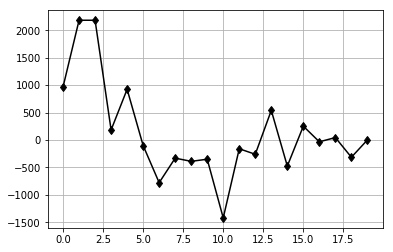

1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [8]:
%%timeit -n1 -r1
from random import random
from math import log
from math import floor
from scipy import stats

#set constants
k1 = 0.015
k2 = 0.00004
k3 = 0.0004
k4 = 0.04

#set time to 0
t = 0

#set initial state k
rabbits = "rabbits"
foxes = "foxes"
    
#calculate cumulative function Rki
def Rki(i, Nk):
    sum = 0.
    for index in range(int(i)):
        sum += Nk[index]
    return sum

#run single interation kmc
def kmc_once(k, t):
    #list transition rates Nk
    Nk = [k1 * k[rabbits],
          k2 * k[rabbits] * k[foxes],
          k3 * k[rabbits] * k[foxes],
          k4 * k[foxes]]

    Qk = Rki(len(Nk), Nk)
    
    #random number
    u = 1 - random()
    uQk = u * Qk
    
    #search Rki-1 < uQk < Rki
    for i in range(1,len(Nk)+1):
        if Rki(i,Nk) >= uQk:
            event_num = i
            break
                    
    #change population
    if event_num == 1:
        k[rabbits] += 1
    elif event_num == 2:
        k[rabbits] -= 1
    elif event_num == 3:
        k[foxes] += 1
    elif event_num == 4:
        k[foxes] -= 1
    else:
        print("Error: state transition not possible (%d)" % event_num)
    
    #another random number, defines the time step
    u = 1 - random()
    try:
        t += (1/Qk)*log(1/u)
    except ZeroDivisionError: #rabbits and foxes die out, go to end
        t = 600
    
    return k, t

#iterate
def iterate_kmc():
    #set time to 0
    t = 0

    #set initial state k
    k = {
        "rabbits": 400,
        "foxes": 200
    }
    
    times = []
    f = []
    r = []
    max_f = 0
    while t < 600:
        times.append(t)
        f.append(k[foxes])
        r.append(k[rabbits])
        output = kmc_once(k, t)
        k = output[0]
        t = output[1]
        
        #second peak (my original soln)
        """
        if t > 200 & f[-1] > 100:
            if f[-1] > max_f:
                max_f = f[-1]
                second_peak_x = t
                second_peak_y = f[-1]
                second_peak = (second_peak_x, second_peak_y)
                """
    
    #second peak from answer (considerably faster this way)
    times = np.array(times)
    r = np.array(r)
    f = np.array(f)
    
    index_of_second_peak = np.argmax(f*(times>200)*(f>100))
    
    second_peak_x = times[index_of_second_peak]
    second_peak_y = f[index_of_second_peak]
    second_peak = (second_peak_x, second_peak_y)
    
    try:
        return times,f,r,second_peak
    except:
        return times,f,r,False

#repeat process to get average response
def convergence(max_number):
    #specify output lists
    num_iterations = []
    location_x = []
    location_y = []
    prob_fox_death = []
    for number in range(1,max_number+1):
        sp_location = []
        instances_death = 0
        print("still going")
        for i in range(number):
            output = iterate_kmc()
            times = output[0]
            f = output[1]
            r = output[2]

            #probability foxes die out before 600 days
            if f[-1] == 0:
                instances_death += 1

            if output[3] != False:
                second_peak = output[3]
                sp_location.append(second_peak) #add to list of second peak locations

        #average location of second peak where foxes > 1000
        summation_x = 0
        summation_y = 0
        num = 0
        for i in range(len(sp_location)):
            if sp_location[i][1] > 1000:
                summation_x += sp_location[i][0]
                summation_y += sp_location[i][1]
                num += 1
        if num != 0:
            summation_x /= num
            summation_y /= num   
            
        prob_death = instances_death/number
        
        num_iterations.append(int(number))
        location_x.append(summation_x)
        location_y.append(summation_y)
        prob_fox_death.append(prob_death)
    return location_x, location_y, prob_fox_death

result = convergence(20)

print("(location_x, location_y, prob_fox_death) = (%f, %f, %f)" %(result[0][-1], result[1][-1], result[2][-1]))

#plot error versus number_iterations
peak_y = result[1]
errors = []
for i in range(len(peak_y)):
    errors.append(-peak_y[i] + peak_y[-1])

q = []
for i in range(20):
    q.append(i)

plt.plot(q, errors, 'kd-')
plt.grid()
plt.show()